In [1]:
import cv2
import pickle
from keras.utils import image_dataset_from_directory
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Using device: cuda


In [2]:
train_pictures_path = r".\GENKI-4K Face, Expression, and Pose Dataset\files"
labeled_pictures_folder = "labeled_pictures"

In [ ]:
files = glob.glob(train_pictures_path+r"\*")
df_train = pd.DataFrame({'full_path': files})
file_name = df_train['full_path'].apply(lambda x: os.path.basename(x))
df_train['file_name'] = file_name
df_train

,full_path,file_name
0,".\GENKI-4K Face, Expression, and Pose Dataset\...",file0001.jpg
1,".\GENKI-4K Face, Expression, and Pose Dataset\...",file0002.jpg
2,".\GENKI-4K Face, Expression, and Pose Dataset\...",file0003.jpg
3,".\GENKI-4K Face, Expression, and Pose Dataset\...",file0004.jpg
4,".\GENKI-4K Face, Expression, and Pose Dataset\...",file0005.jpg
...,...,...
3995,".\GENKI-4K Face, Expression, and Pose Dataset\...",file3996.jpg
3996,".\GENKI-4K Face, Expression, and Pose Dataset\...",file3997.jpg
3997,".\GENKI-4K Face, Expression, and Pose Dataset\...",file3998.jpg
3998,".\GENKI-4K Face, Expression, and Pose Dataset\...",file3999.jpg


In [ ]:
# ! pip install opencv-python --upgrade

In [3]:
!gdown 1aqH0YQHn8pSpWmno8l3CZ8SGsLTRxKXq

Downloading...
From (original): https://drive.google.com/uc?id=1aqH0YQHn8pSpWmno8l3CZ8SGsLTRxKXq
From (redirected): https://drive.google.com/uc?id=1aqH0YQHn8pSpWmno8l3CZ8SGsLTRxKXq&confirm=t&uuid=aaa3433b-718f-41fc-8761-20f24415e493
To: /content/labeled_pictures.zip
100% 57.1M/57.1M [00:01<00:00, 55.2MB/s]


In [4]:
!unzip labeled_pictures.zip > /dev/null 2>&1

In [5]:
max_width = 256
max_height = 256
max_width, max_height

(256, 256)

In [6]:
SEED = 42

train_dataset = image_dataset_from_directory(
   directory= rf'./{labeled_pictures_folder}/',
   labels='inferred',
   label_mode='categorical',
   color_mode='rgb',
   shuffle = True,
   subset='training',
   validation_split=0.1,
   seed=SEED,
   batch_size=32,
   image_size=(max_width, max_height),
   interpolation='bilinear'
)

class_names = train_dataset.class_names
print('Class names:', class_names)


Found 4000 files belonging to 2 classes.
Using 3600 files for training.
Class names: ['0', '1']


In [7]:
val_dataset = image_dataset_from_directory(
   directory = rf'./{labeled_pictures_folder}/',
   labels = 'inferred' ,
   label_mode = 'categorical',
   color_mode ='rgb',
   shuffle = True,
   subset = 'validation',
   validation_split = 0.1,
   seed = SEED,
   batch_size = 32,
   image_size = (max_width, max_height),
   interpolation = 'bilinear'
)

Found 4000 files belonging to 2 classes.
Using 400 files for validation.


In [8]:
from keras.applications.inception_resnet_v2 import preprocess_input

# Preprocess the data
train_dataset_preprocess = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset_preprocess = val_dataset.map(lambda x, y: (preprocess_input(x), y))

In [10]:
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(max_width, max_height, 3),
    # classes=2,
    classifier_activation="softmax",
    name="inception_resnet_v2"
)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
base_model.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=conv2d, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Activation name=activation, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Activation name=activation_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <Activation name=activation_2, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <BatchNormalization name=batch_normalization_3, built=True>,
 <Activation name=activation_3, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <BatchNormalization name=batch_normalization_4, built=True>,
 <Activation name=activation_4, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_8, built=True>,
 <BatchNormalization name=batch_normalization_8, built=True>,
 <Activation name=activation_8, built=True>,


In [12]:
len(base_model.layers)

780

In [13]:
len(base_model.trainable_variables)

488

In [17]:
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
  layer.trainable = True

In [18]:
len(base_model.layers)

780

In [19]:
len(base_model.trainable_variables)

362

In [20]:
inputs = keras.Input(shape=(max_width, max_height, 3))
x = base_model(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64,activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)

model = keras.models.Model(inputs, outputs)

In [21]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 6, 6, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 55296)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,539,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,884,322 (220.81 MB)

 Trainable params: 56,488,882 (215.49 MB)

 Non-trainable params: 1,395,440 (5.32 MB)

None


In [22]:
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'] # TODO
)

In [23]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy')
history = model.fit(
   train_dataset_preprocess,
   epochs=100,
   validation_data=val_dataset_preprocess,
   callbacks=[early_stopping_cb]
)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.6238 - loss: 1.0156 - precision: 0.6238 - recall: 0.6238 - val_accuracy: 0.8625 - val_loss: 0.9170 - val_precision: 0.8625 - val_recall: 0.8625
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - accuracy: 0.8990 - loss: 0.3522 - precision: 0.8990 - recall: 0.8990 - val_accuracy: 0.9225 - val_loss: 4.2456 - val_precision: 0.9225 - val_recall: 0.9225
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 569ms/step - accuracy: 0.9177 - loss: 0.2426 - precision: 0.9177 - recall: 0.9177 - val_accuracy: 0.9250 - val_loss: 0.2349 - val_precision: 0.9250 - val_recall: 0.9250
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 571ms/step - accuracy: 0.9460 - loss: 0.1648 - precision: 0.9460 - recall: 0.9460 - val_accuracy: 0.9425 - val_loss: 0.2187 - val_precision: 0.9425 - val_recall: 0.9425
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 570ms/step - accuracy: 0.9518 - loss: 0.1213 - precision: 0.9518 - recall: 0.9518 - val_accuracy: 0.

In [24]:
model.save("Smile_Detector_Model_InceptionResNetV2.keras")

In [25]:
model = keras.saving.load_model("Smile_Detector_Model_InceptionResNetV2.keras")

In [29]:
model.evaluate(val_dataset_preprocess)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.9402 - loss: 0.2339 - precision: 0.9402 - recall: 0.9402


[0.21867485344409943,
 0.9424999952316284,
 0.9424999952316284,
 0.9424999952316284]

In [30]:
predictions = model.predict(val_dataset_preprocess)
predicted_classes = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in val_dataset_preprocess], axis=0)
true_classes = np.argmax(true_labels, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


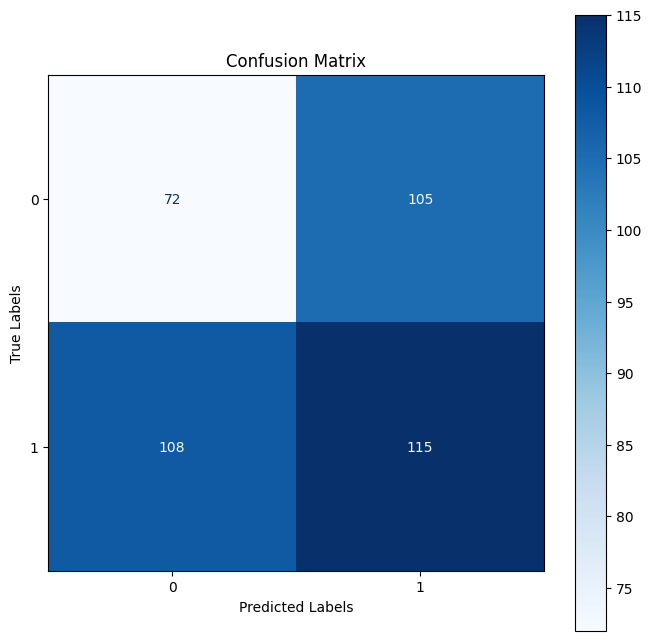

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_classes, predicted_classes)
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()